# CMIP6 superposed epoch analysis
This notebook analyses global and Australian monthly temperature and precipitation anomalies in the decade surrounding the five major volcanic eruptions since 1850 - Krakatau 1883, Santa Maria 1902, Agung 1963, El Chicon 1982, Pinatubo 1991 - using CMIP6 historical model output (43 models).    
It then overlays the time series for each volcanic eruption, takes the average across the volcanic eruptions and plots the results. 

In [1]:
import xarray as xr, matplotlib.pyplot as plt
from importlib import reload 
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
from matplotlib.colors import LinearSegmentedColormap 
import seaborn as sns
import dask.diagnostics
import scipy

Matplotlib is building the font cache; this may take a moment.


In [3]:
# import custom functions
import sys 
sys.path.append('/g/data/w40/W48_GDATA_MOVED/kb6999/Masters_paper') 
import GRL_functions as func

In [22]:
path = '/g/data/w40/W48_GDATA_MOVED/kb6999/Models/'

### Load model data

In [5]:
# Define each section of the directory where the models are stored
institution_dir = '/g/data/lp01/CMIP6/CMIP/'
tas_dir = '/historical/r1i1p1f1/Amon/tas/gr1.5/'
pr_dir = '/historical/r1i1p1f1/Amon/pr/gr1.5/'

In [6]:
# use the read_models function to read in CMIP6 model data from 1850-2015
models_tas = func.read_models(institution_dir, tas_dir, '1850-01','2015-01')

55 model paths found and loaded into the dictionary "models"
55 models have been successfully loaded into an xarray


In [7]:
models_pr = func.read_models(institution_dir, pr_dir, '1850-01','2015-01')

52 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
51 models have been successfully loaded into an xarray


In [8]:
# select out the 43 models that were available at the time
models_43 = ['ACCESS-CM2','ACCESS-ESM1-5','AWI-CM-1-1-MR','AWI-ESM-1-1-LR','BCC-CSM2-MR','BCC-ESM1',
                             'CAMS-CSM1-0', 'CAS-ESM2-0', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 
                             'CMCC-CM2-HR4', 'CMCC-CM2-SR5' ,'CanESM5', 'E3SM-1-1' ,'E3SM-1-1-ECA' ,'EC-Earth3', 
                             'EC-Earth3-AerChem' , 'EC-Earth3-Veg-LR', 'FGOALS-f3-L' ,'FGOALS-g3', 'FIO-ESM-2-0', 
                             'GFDL-CM4' ,'GFDL-ESM4', 'GISS-E2-1-G' ,'GISS-E2-1-G-CC', 'GISS-E2-1-H' ,'IITM-ESM', 
                             'INM-CM4-8', 'INM-CM5-0' ,'IPSL-CM6A-LR', 'KACE-1-0-G', 'MIROC6' ,'MPI-ESM-1-2-HAM',
                             'MPI-ESM1-2-LR' ,'MRI-ESM2-0', 'NESM3', 'NorCPM1' ,'NorESM2-LM', 'NorESM2-MM',
                             'SAM0-UNICON', 'TaiESM1']

In [9]:
# make sure the models are the same for both vairables
# delete the height from the models_tas array (if it hasn't been deleted already)
if 'height' in models_tas:
    del models_tas['height']
# delete models that aren't common between variables
models_tas = models_tas.sel(model= models_43)
models_pr = models_pr.sel(model= models_43)
#chekc that the models are the same for both variables and if so print True
models_tas.model.equals(models_pr.model)

True

In [10]:
# combine precipitation and temperature into one dataset
models = xr.Dataset({'tas': models_tas.tas, 'pr': models_pr.pr})
# change the pr units into mm/day
models['pr'] = models.pr*86400
models

<xarray.Dataset>
Dimensions:  (lon: 240, lat: 120, time: 1980, model: 43)
Coordinates:
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5
  * lat      (lat) float64 -89.25 -87.75 -86.25 -84.75 ... 86.25 87.75 89.25
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2014-12-31
  * model    (model) <U17 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'TaiESM1'
Data variables:
    tas      (model, time, lat, lon) float32 dask.array<chunksize=(1, 12, 120, 240), meta=np.ndarray>
    pr       (model, time, lat, lon) float64 dask.array<chunksize=(1, 12, 120, 240), meta=np.ndarray>

In [11]:
# sort models alphabetically and prints final model list
models = models.sortby('model')
print('The following', len(models.model.data), 'models will be used in all subsequent calculations: \n')
print(models.model.data)

The following 43 models will be used in all subsequent calculations: 

['ACCESS-CM2' 'ACCESS-ESM1-5' 'AWI-CM-1-1-MR' 'AWI-ESM-1-1-LR'
 'BCC-CSM2-MR' 'BCC-ESM1' 'CAMS-CSM1-0' 'CAS-ESM2-0' 'CESM2' 'CESM2-FV2'
 'CESM2-WACCM' 'CESM2-WACCM-FV2' 'CMCC-CM2-HR4' 'CMCC-CM2-SR5' 'CanESM5'
 'E3SM-1-1' 'E3SM-1-1-ECA' 'EC-Earth3' 'EC-Earth3-AerChem'
 'EC-Earth3-Veg-LR' 'FGOALS-f3-L' 'FGOALS-g3' 'FIO-ESM-2-0' 'GFDL-CM4'
 'GFDL-ESM4' 'GISS-E2-1-G' 'GISS-E2-1-G-CC' 'GISS-E2-1-H' 'IITM-ESM'
 'INM-CM4-8' 'INM-CM5-0' 'IPSL-CM6A-LR' 'KACE-1-0-G' 'MIROC6'
 'MPI-ESM-1-2-HAM' 'MPI-ESM1-2-LR' 'MRI-ESM2-0' 'NESM3' 'NorCPM1'
 'NorESM2-LM' 'NorESM2-MM' 'SAM0-UNICON' 'TaiESM1']


### Area weighting

In [12]:
# area weighting 
models_w = models*np.cos(models.lat*(np.pi/180))

All the models are now stored in one array so from hereafter can calculate anomalies etc. 

### Eruption dates

In [13]:
# Define eruption dates for each of the five major eruptions: Krakatau, Santa Maria, Agung, El Chichon, Pinatubo
e_date = pd.to_datetime(['1883-08','1902-10', '1963-03', '1982-04', '1991-06'])

In [14]:
# save arrays of times relative to each eruption
e_pre5yrs = e_date - 60 * pd.offsets.MonthBegin()
e_pre3mon = e_date - 3 * pd.offsets.MonthBegin()
e_post5yrs = e_date + 61 * pd.offsets.MonthBegin()

In [16]:
# select out hte 10 year time frame around each eruption (5yrs before and after)
Krakatau = models_w.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
SantaMaria = models_w.sel(time = slice(e_pre5yrs[1], e_post5yrs[1]))
Agung = models_w.sel(time = slice(e_pre5yrs[2], e_post5yrs[2]))
ElChicon = models_w.sel(time = slice(e_pre5yrs[3], e_post5yrs[3]))
Pinatubo = models_w.sel(time = slice(e_pre5yrs[4], e_post5yrs[4]))

### Anomalies

In [19]:
# use functions to calculate the monthly anomalies for the globe
K_mon_anom_Glob = func.monthly_anomaly(Krakatau, e_pre5yrs[0], e_pre3mon[0])
S_mon_anom_Glob = func.monthly_anomaly(SantaMaria, e_pre5yrs[1], e_pre3mon[1])
A_mon_anom_Glob = func.monthly_anomaly(Agung, e_pre5yrs[2], e_pre3mon[2])
E_mon_anom_Glob = func.monthly_anomaly(ElChicon, e_pre5yrs[3], e_pre3mon[3])
P_mon_anom_Glob = func.monthly_anomaly(Pinatubo, e_pre5yrs[4], e_pre3mon[4])

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/

In [20]:
times = np.arange(-60,61)
# reset all the times so 0 corresponds to the eruption year and month
K_mon_anom_Glob['time'] = times
S_mon_anom_Glob['time'] = times
A_mon_anom_Glob['time'] = times
E_mon_anom_Glob['time'] = times 
P_mon_anom_Glob['time'] = times

# delete the months dimension (but not the time)
if 'month' in P_mon_anom_Glob:
    del K_mon_anom_Glob['month']
    del S_mon_anom_Glob['month']
    del A_mon_anom_Glob['month']
    del E_mon_anom_Glob['month']
    del P_mon_anom_Glob['month']

In [29]:
# import land fraction data
landfrac_ds = xr.open_dataset(f'{path}landfraction_file_grid1.5.nc')
landmask = landfrac_ds.mean(dim='time')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:153: SerializationWarning: Ambiguous reference date string: 1-01-01 01:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-01-01 01:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axi

In [30]:
#  select out each region for each volcano
K_mon_Aus = K_mon_anom_Glob.sel(lat=slice(-50,-10), lon=slice(110,160)).where(landmask.data==1, drop=True)
S_mon_Aus = S_mon_anom_Glob.sel(lat=slice(-50,-10), lon=slice(110,160)).where(landmask.data==1, drop=True)
A_mon_Aus = A_mon_anom_Glob.sel(lat=slice(-50,-10), lon=slice(110,160)).where(landmask.data==1, drop=True)
E_mon_Aus = E_mon_anom_Glob.sel(lat=slice(-50,-10), lon=slice(110,160)).where(landmask.data==1, drop=True)
P_mon_Aus = P_mon_anom_Glob.sel(lat=slice(-50,-10), lon=slice(110,160)).where(landmask.data==1, drop=True)

In [33]:
# calculate the monthly model mean for global monthly anomalies
K_llm_Glob = K_mon_anom_Glob.mean(dim=('lat','lon'))
S_llm_Glob = S_mon_anom_Glob.mean(dim=('lat','lon'))
A_llm_Glob = A_mon_anom_Glob.mean(dim=('lat','lon'))
E_llm_Glob = E_mon_anom_Glob.mean(dim=('lat','lon'))
P_llm_Glob = P_mon_anom_Glob.mean(dim=('lat','lon'))

In [35]:
# calculate the monthly model mean for Australian monthly anomalies
K_llm_Aus = K_mon_Aus.mean(dim=('lat','lon'))
S_llm_Aus = S_mon_Aus.mean(dim=('lat','lon'))
A_llm_Aus = A_mon_Aus.mean(dim=('lat','lon'))
E_llm_Aus = E_mon_Aus.mean(dim=('lat','lon'))
P_llm_Aus = P_mon_Aus.mean(dim=('lat','lon'))

### Combine eruptions

In [ ]:
# eruption names
volcanoes = ['Krakatau', 'Santa Maria','Agung','El Chichon', 'Pinatubo']

In [36]:
# Combine temperature data for all eruptions into one array
composite_llm_Glob_tas = func.SEA_combine(K_llm_Glob, S_llm_Glob, A_llm_Glob, E_llm_Glob, P_llm_Glob, volcanoes)
composite_llm_Aus_tas = func.SEA_combine(K_llm_Aus, S_llm_Aus, A_llm_Aus, E_llm_Aus, P_llm_Aus, volcanoes)

In [37]:
# Combine precipitation data for all eruptions into one array f
composite_llm_Glob_pr = func.SEA_combine(K_llm_Glob, S_llm_Glob, A_llm_Glob, E_llm_Glob, P_llm_Glob, volcanoes)
composite_llm_Aus_pr = func.SEA_combine(K_llm_Aus, S_llm_Aus, A_llm_Aus, E_llm_Aus, P_llm_Aus, volcanoes)

In [38]:
# combine temperature and precipitation into one data set 
composite_llm_Glob = xr.Dataset({'tas': composite_llm_Glob_tas.tas, 'pr': composite_llm_Glob_pr.pr})
composite_llm_Aus = xr.Dataset({'tas': composite_llm_Aus_tas.tas, 'pr': composite_llm_Aus_pr.pr})

Right now I have all the models stored in one array so from hereafter I can calculate anomalies etc.  
## Select out regions and eruption dates

In [40]:
# take the composite over all volcanoes
composite_mmm_Glob = composite_llm_Glob.mean(dim='model')
composite_mmm_Aus = composite_llm_Aus.mean(dim='model')

In [41]:
# take the mean/composite over all volcanoes
V_composite_mmm_Glob = composite_mmm_Glob.mean(dim='volcano')
V_composite_mmm_Aus = composite_mmm_Aus.mean(dim='volcano')

In [42]:
# calculate the percentiles and then take the mean along the model dimension for monthly anomalies
p10_Glob = composite_llm_Glob.chunk({'model': -1,'volcano': -1}).quantile(0.1, dim=['model', 'volcano'])
p10_Aus = composite_llm_Aus.chunk({'model': -1,'volcano': -1}).quantile(0.1, dim=['model', 'volcano'])

p90_Glob = composite_llm_Glob.chunk({'model': -1,'volcano': -1}).quantile(0.9, dim=['model', 'volcano'])
p90_Aus = composite_llm_Aus.chunk({'model': -1,'volcano': -1}).quantile(0.9, dim=['model', 'volcano'])

# Figures

In [43]:
# set the default font size
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [44]:
# create custom colour groups for plots
reds = ['crimson', 'maroon', 'orangered', 'orange', 'pink']
greens = ['darkgreen','lime','#68CB61', 'olivedrab', '#E5FCDA']

In [45]:
# define degree sign
deg = u'\N{DEGREE SIGN}'

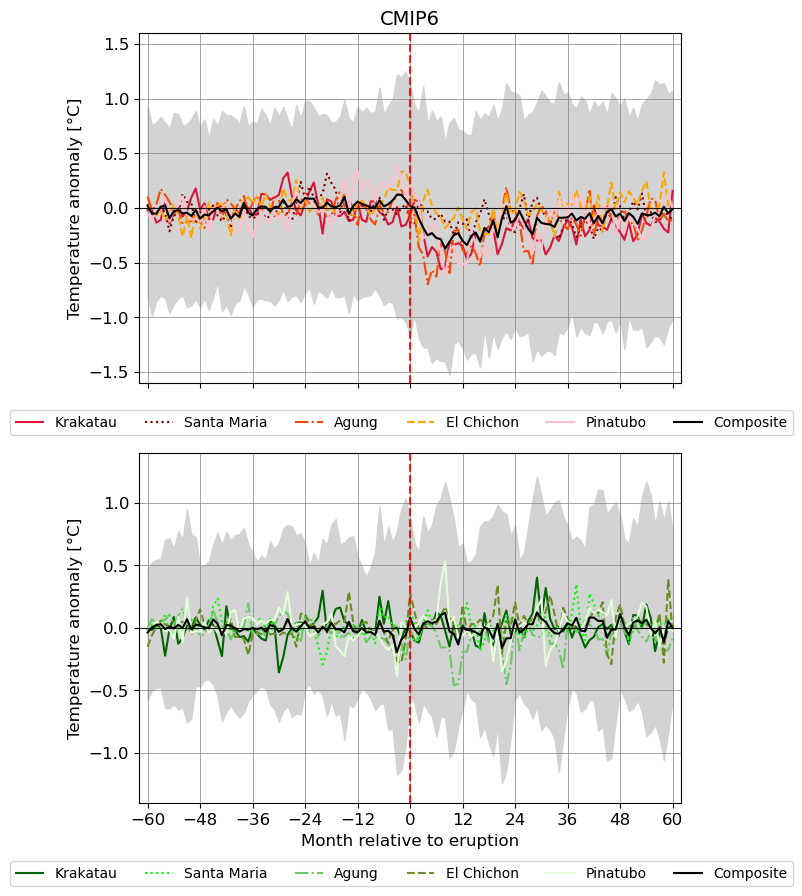

In [46]:
# legend in centre
# plot Australian monthly anomalies of temperature as a superposed epoch analysis of all 5 eruptions plus composite
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(7,10))

# make subplots for each region
func.SEA_plots(composite_mmm_Aus.tas, V_composite_mmm_Aus.tas, p10_Aus.tas, p90_Aus.tas, reds, ax = axes[0])
func.SEA_plots(composite_mmm_Aus.pr, V_composite_mmm_Aus.pr, p10_Aus.pr, p90_Aus.pr, greens, ax = axes[1])

# set axis labels and subplot titles
axes[0].set(ylabel = f'Temperature anomaly [{deg}C]', title = 'CMIP6') 
axes[1].set(xlabel = 'Month relative to eruption', ylabel = f'Temperature anomaly [{deg}C]')

# remove minor gridlines 
axes[0].minorticks_off()
axes[1].minorticks_off()
# set axis limits 
axes[0].set_xlim(-62, 62)
axes[1].set_xlim(-62, 62)
axes[0].set_ylim(-1.6, 1.6)
axes[1].set_ylim(-1.4, 1.4)

#set legends
handles_t, labels_t = axes[0].get_legend_handles_labels()
handles_p, labels_p = axes[1].get_legend_handles_labels()

# create legend (first arg to bbox is x, second is y)
fig.legend(handles_t, labels_t, loc='upper center', bbox_to_anchor=(0.5, 0.51), ncol=6) 
fig.legend(handles_p, labels_p, loc='lower center', bbox_to_anchor=(0.5, 0.02), ncol=6) 

### Global

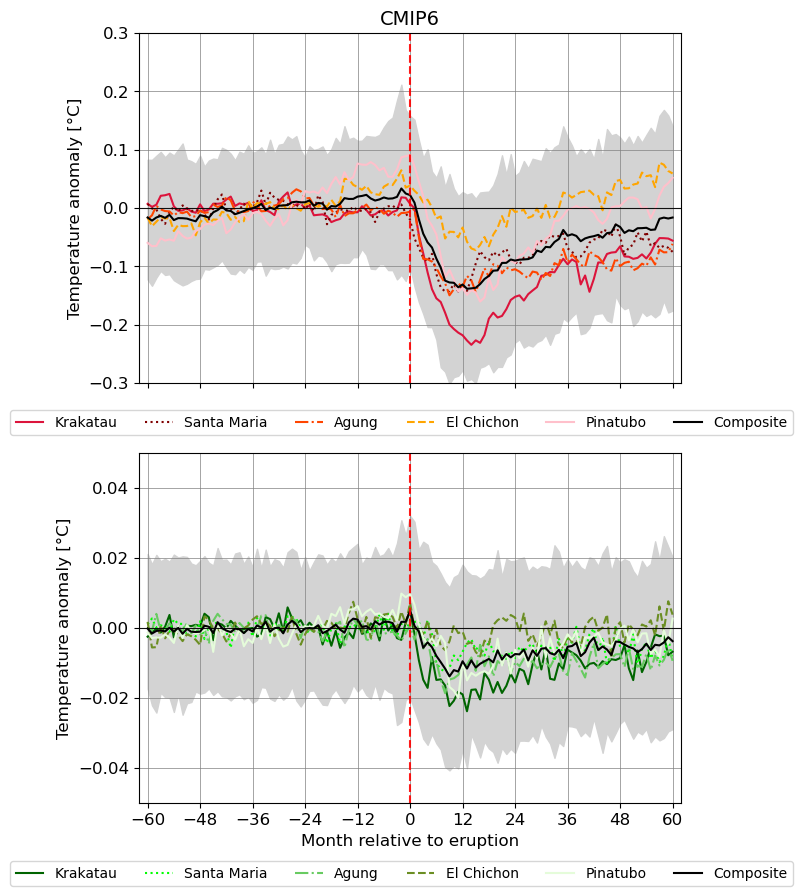

In [47]:
# legend in centre
# plot global monthly anomalies of temperature as a superposed epoch analysis of all 5 eruptions plus composite
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(7,10))

# make subplots for each region
func.SEA_plots(composite_mmm_Glob.tas, V_composite_mmm_Glob.tas, p10_Glob.tas, p90_Glob.tas, reds, ax = axes[0])
func.SEA_plots(composite_mmm_Glob.pr, V_composite_mmm_Glob.pr, p10_Glob.pr, p90_Glob.pr, greens, ax = axes[1])

# set axis labels and subplot titles
axes[0].set(ylabel = f'Temperature anomaly [{deg}C]', title = 'CMIP6') 
axes[1].set(xlabel = 'Month relative to eruption', ylabel = f'Temperature anomaly [{deg}C]')

# remove minor gridlines 
axes[0].minorticks_off()
axes[1].minorticks_off()
# set axis limits 
axes[0].set_xlim(-62, 62)
axes[1].set_xlim(-62, 62)
axes[0].set_ylim(-0.3, 0.3)
axes[1].set_ylim(-0.05, 0.05)

# set legends
handles_t, labels_t = axes[0].get_legend_handles_labels()
handles_p, labels_p = axes[1].get_legend_handles_labels()

# create legend (first arg to bbox is x, second is y)
fig.legend(handles_t, labels_t, loc='upper center', bbox_to_anchor=(0.5, 0.51), ncol=6) 
fig.legend(handles_p, labels_p, loc='lower center', bbox_to_anchor=(0.5, 0.02), ncol=6) 